### Imports

In [1]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and True:
  from google.colab import drive
  drive.mount('/content/drive')
if True:
  os.chdir(find_path('wishart.py')[0][1])

Mounted at /content/drive


In [ ]:
!pip -q install dbscan1d
#!pip -q install hdbscan
!pip -q install sklearn

In [3]:
import itertools
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import warnings
from dbscan1d.core import DBSCAN1D
from sklearn.cluster import DBSCAN
#from sklearn.cluster import HDBSCAN
from wishart import Wishart
from scipy import stats
from scipy.spatial import distance
from tqdm import tqdm
import warnings

In [4]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns

### Time series generation

#### Chaotic Dataset

In [57]:
# Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    return x

In [58]:
# Logistic map
def logistic_map(n=2**15, r=4, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
    return x

In [59]:
# Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    z = float(z)
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    return x

In [60]:
# Henon map
def henon_map(n=1000000, a=1.4, b=0.3, x0=0.2 ,y0=0.1):
    x = np.zeros(n)
    y = np.zeros(n)
    x[0] = x0
    y[0] = y0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + y[i-1]
        y[i] = b * x[i-1]
    return x

#### Sine Dataset (Deterministic)

In [61]:
sine_data = np.sin(np.arange(0,1000,.01))

#### Gaussian Noise (Stochastic)

In [62]:
gaussian_noise = np.random.normal(size=100000)

#### Lorenz

In [63]:
file_path = 'lorenz.txt'

# Read data from the file into a NumPy array
with open(file_path, 'r') as file:
    # Use numpy to convert the lines into a 1D array of floats
    lorenz = np.array([float(line.strip()) for line in file.readlines()])

# Print the resulting NumPy array
print(lorenz)

[0.53696553 0.57039027 0.68672766 ... 0.6160236  0.71350847 0.86349486]


## Baseline

#### Take our data, genearate patterns, take motivs from TS

In [64]:
t_start = 13000
# choose only part of data
x = np.float32(np.array(lorenz)[t_start:t_start+10000])
y_true = np.float32(np.array(lorenz)[t_start+10000:t_start+10000+600])

In [65]:
# generate patterns of tau (distance betwean points in motivs)
chunk_len=10
pattern_set = list(itertools.product(range(1, chunk_len+1),  repeat=3))

In [66]:
# from our data for each pattern take motivs
def ones_patters(a, n, pat = None):
    if pat == None:
        pat = np.int_(np.ones(n))
    b = np.int_(np.append([0], np.cumsum(pat)))
    l = []
    for i in range(a.shape[0] - np.sum(pat)):
        l.append(a[b].reshape(1, -1))
        b = b + 1
    return np.concatenate(l, axis = 0)
#####################################################
warnings.filterwarnings("ignore")

# Extract Samples
Ca_set_direct  = np.array([ones_patters(x, 3, pat = pattern) for pattern in pattern_set])

#### Base Prediction function

In [67]:
def Predict_pull(pattern_set, x, pattern_samples, eps=0.01, sigma=0.01, tresh_size1=0.4, tresh_diff=0.2, eps_cl=0.005, min_samples_cl=5):

        ##########
        def C(pattern, x):  # Return data based on the pattern set

            c_ = len(x) - np.cumsum(pattern[::-1])

            return x[c_][::-1]
        ##########

        def Possible_predictions(pattern, x, Ca):
            C_ = C(pattern, x).tolist()   # Extract last elements based on the patterns [x1, x2, x3]
            C_ = [np.float32(i) if i != 'N' else 'N' for i in C_]   # check if the element is predictable
            TrCa = Ca[:,:-1]

            if 'N' in C_:
                return []
            else:
                d = distance.cdist(TrCa, [C_], 'euclidean')
                closed_mot_index = np.where(d < eps)[0]
                Possible_predictions_ = Ca[closed_mot_index, -1]

                return Possible_predictions_
        ##########

        def prediction_one_step(Q):
            Qreshape = Q.reshape(len(Q),1)

            # DBSCAN1D clustering
            c = DBSCAN1D(eps=eps_cl, min_samples=min_samples_cl)
            l = c.fit_predict(Qreshape)   # Fit the model

            count_cl = np.array(np.unique(l, return_counts = True)).T   # number of samples in each cluster

            count_cl_without_noize = count_cl[~np.isin(count_cl[:,0],[-1])]  # remove noise (class -1)

            if count_cl_without_noize.shape[0] == 0:    # not predictable if there is no cluster

                return 'N'
            else:

                # Sort clusters based on the number of samples in each cluster
                count_cl_without_noize_sorted = count_cl_without_noize[np.argsort(count_cl_without_noize[:,1]), :]
                # print(count_cl_without_noize_sorted)

                # Check the ratio of samples for the biggest cluster to all samples
                size1 = count_cl_without_noize_sorted[-1, 1] / Q.size

                if count_cl_without_noize_sorted.shape[0] > 1:
                    # Check the second biggest cluster ratio to all samples
                    size2 = count_cl_without_noize_sorted[-2, 1] / Q.size
                else:
                    size2 = 0

                if size2 != 0:
                    # tresh_size1 = 0.4, tresh_diff = 0.2
                    if (size1 < tresh_size1) | (size1 - size2 < tresh_diff):   # Don't have enough samples to predict

                        return 'N'
                    else:
                        # Use mean method to calculate the one step prediction ahead
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, sigma, 1)[0]
                else:
                    if size1 < tresh_size1:

                        return 'N'
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, sigma, 1)[0]

        Qlist = np.array([Possible_predictions(pattern_set[i], x, pattern_samples[i]) for i in  range(len(pattern_set))])
        Q = np.hstack(Qlist)
        if len(Q) == 0:
            return 'N'
        else:

            return prediction_one_step(Q)

#### Make our predictions

In [68]:
predictions_list_baseline = []
T_list = [50, 100]
for i in range(len(T_list)):
    print('Compute for T=', T_list[i])
    pred = []
    for t in range(T_list[i]):
        a = Predict_pull(pattern_set, np.append(x, pred), Ca_set_direct, eps=0.005, sigma=0.0, tresh_size1=0.4, tresh_diff=0.2, eps_cl=0.005, min_samples_cl=5)
        pred.append(a)
    predictions_list_baseline.append(pred)

Compute for T= 50
Compute for T= 100


#### Plot predictions

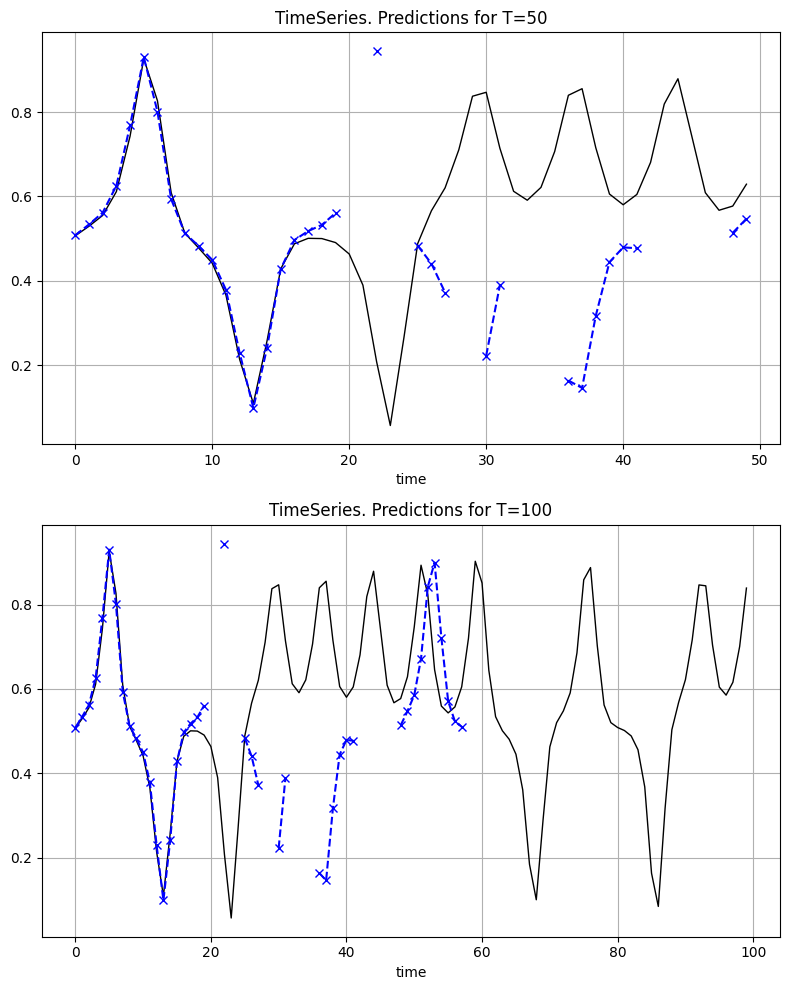

In [81]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize = (8, 10))


for i in range(len(T_list)):
    pred = predictions_list_baseline[i]
    T = T_list[i]

    pred_ = [pred[i] if pred[i] != 'N' else np.nan for i in range(T)]
    axes[i].plot(np.arange(T), y_true[:T], color='k', linewidth=1)
    axes[i].plot(np.arange(T), pred_, color='b', marker='x', ls='--')
    axes[i].set_title(f"TimeSeries. Predictions for T={T}")

for ax in axes:
  ax.grid()
  ax.set_xlabel("time")

fig.tight_layout()
fig.show()

## Method from seminar. Predictive Clustering

#### Functions for taking patterns and motivs

Generating patterns

In [70]:
def generate_patterns(K, L):
    """
    generate all patterns like in baseline
    """
    patterns = np.array(list(itertools.product(np.arange(1, K+1), repeat=L-1)))
    return patterns
patterns = generate_patterns(10, 4)
patterns

array([[ 1,  1,  1],
       [ 1,  1,  2],
       [ 1,  1,  3],
       ...,
       [10, 10,  8],
       [10, 10,  9],
       [10, 10, 10]])

Generating motives

In [71]:
def get_samples(x, pattern):
    """
    take our motives for pattern
    """
    inds = np.array([0, *np.cumsum(pattern)])
    return np.array(
        [x[inds+i] for i in range(len(x)-inds[-1])]
    )


def get_motives(x, patterns, clusters=False):

    if not clusters:
        return [get_samples(x, pattern) for pattern in tqdm(patterns)]

    motives = []
    for pattern in tqdm(patterns):
        samples = get_samples(x, pattern)

        lorenz_WC = Wishart(11, 0.2)
        _ = lorenz_WC.fit(samples)

        cluster_centers = []

        # zero cluster is noise
        for l in range(len(lorenz_WC.clusters_to_objects)):
            cluster_l = samples[lorenz_WC.clusters_to_objects[l]]

            if l == 0 or len(cluster_l) == 0:
                continue

            cluster_centers.append(list(np.mean(cluster_l, axis=0)))

        motives.append(np.array(cluster_centers))
    return motives

#### Take all motives

In [86]:
x_train, x_test = lorenz[t_start:t_start+10000], lorenz[t_start+10000:t_start+10000+600]

motives = get_motives(x_train, patterns)

100%|██████████| 1000/1000 [00:32<00:00, 30.53it/s]


#### Function to take prediction

In [73]:
def get_single_prediction(set_predictions, distances, method):
    """
    make prediction
    """
    if len(set_predictions) == 0:
        return np.nan
    if method == 'mode':
        return stats.mode(set_predictions)[0]
    elif method == 'mean':
        return np.mean(set_predictions)
    elif method == 'median':
        return np.median(set_predictions)
    elif method == 'dbscan':
        eps, min_samples = 0.01, 5
        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        dbs.fit(set_predictions.reshape(-1, 1))
        cluster_labels, cluster_sizes = np.unique(dbs.labels_[dbs.labels_ > -1], return_counts=True)

        if cluster_labels.size == 1:
            prediction = set_predictions[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction

        max_cluster1, max_cluster2 = np.sort(cluster_sizes)[-2:]

        if max_cluster2 / max_cluster1 < 3:
            return np.nan

        if cluster_labels.size > 0:
            prediction = set_predictions[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction
    else:
      print("Error: method of choosing point from set of prediction is not define")

def get_set_of_predictions(X, motives, patterns, f_dist, eps=0.005):
    set_predictions = []
    distances = []
    for i in range(len(patterns)):
        new_motive = X[-np.cumsum(patterns[i][::-1])[::-1]]

        distances_i = f_dist(new_motive, motives[i][:, :-1])
        good_inds = distances_i < eps

        distances.extend(distances_i[good_inds])
        set_predictions.extend(motives[i][:,-1][good_inds])

    return np.array(set_predictions), np.array(distances)

def f_dist(x, y):
    return np.linalg.norm(x-y, axis=1)

#### Predict and plot

In [74]:
T = 100
baseline_pred  = predictions_list_baseline[1]
baseline_pred = [baseline_pred[i] if baseline_pred[i] != 'N' else np.nan for i in range(len(baseline_pred))]
predictions_list = [baseline_pred]
method_list = ["baseline",
               "mode",
               "mean",
               "median",
               "dbscan"]

T = 100
new_x_train = x_train.copy()

for i in range(1, len(method_list)):
    print('Compute for method=', method_list[i])
    pred = []
    for t in range(T):
        set_of_predictions, distances = get_set_of_predictions(new_x_train, motives, patterns, f_dist, 0.01)
        x_pred = get_single_prediction(set_of_predictions, distances, method=method_list[i])
        pred.append(x_pred)
        new_x_train = np.append(new_x_train, x_pred)
    predictions_list.append(pred)

Compute for method= mode
Compute for method= mean
Compute for method= median
Compute for method= dbscan


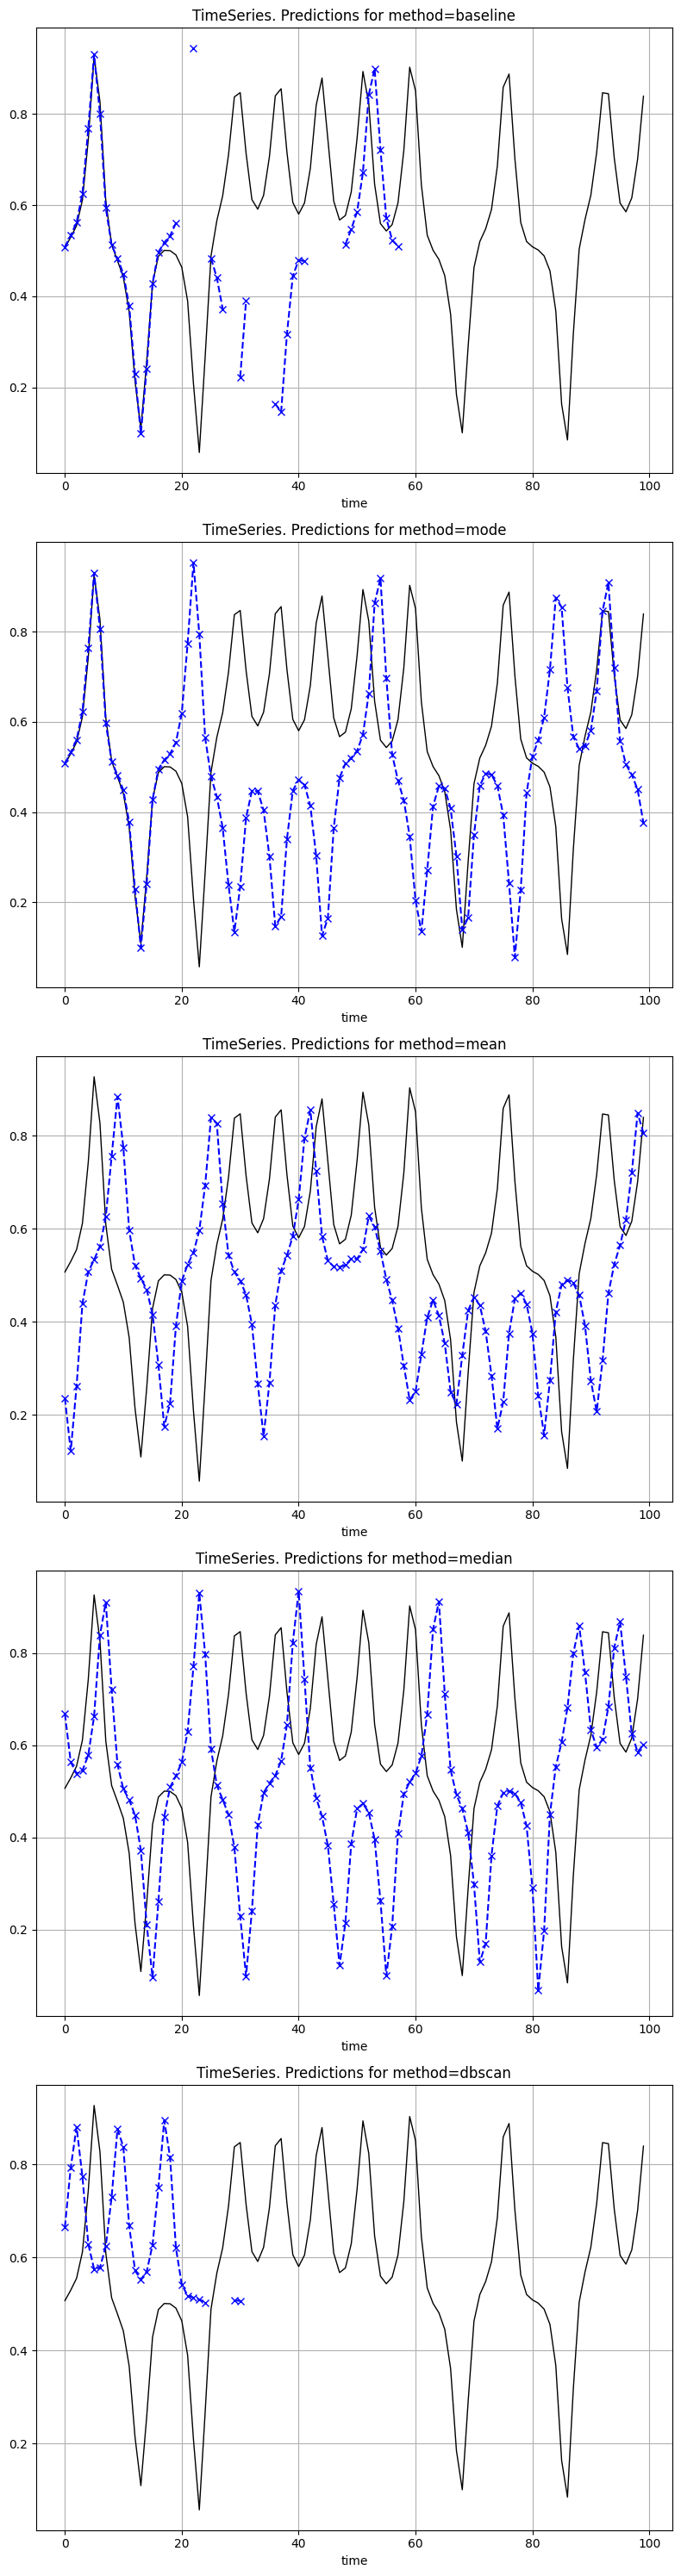

In [87]:
gr_num= len(method_list)
fig, axes = plt.subplots(gr_num, 1, sharex=False, figsize = (8, 6*gr_num))

T=100
for i in range(len(method_list)):
    pred = predictions_list[i]

    axes[i].plot(np.arange(T), x_test[:T], color='k', linewidth=1)
    axes[i].plot(np.arange(T), pred, color='b', marker='x', ls='--')
    axes[i].set_title(f"TimeSeries. Predictions for method={method_list[i]}")

for ax in axes:
  ax.grid()
  ax.set_xlabel("time")

fig.tight_layout()
fig.show()

#### Error

In [102]:
from sklearn.metrics import mean_absolute_error

for T in [10, 15, 25, 50, 100]:
  print("T=",T)
  for i in range(len(method_list)):
      print(f'{method_list[i]} MAE={np.nanmean(np.abs(x_test[:T] - predictions_list[i][:T])):.5f}')
  print()

T= 10
baseline MAE=0.01013
mode MAE=0.00809
mean MAE=0.27052
median MAE=0.13089
dbscan MAE=0.22549

T= 15
baseline MAE=0.01097
mode MAE=0.00940
mean MAE=0.27812
median MAE=0.13560
dbscan MAE=0.27107

T= 25
baseline MAE=0.04906
mode MAE=0.10314
mean MAE=0.26115
median MAE=0.20039
dbscan MAE=0.26260

T= 50
baseline MAE=0.13757
mode MAE=0.21633
mean MAE=0.24036
median MAE=0.24285
dbscan MAE=0.26800

T= 100
baseline MAE=0.13460
mode MAE=0.21533
mean MAE=0.23102
median MAE=0.25048
dbscan MAE=0.26800

